# Variational Quantum Eigensolver improved with Zero Noise Extrapolation 

In this example we investigate how Zero Noise Extrapolation (ZNE) can improve 
convergence when applied to a variational problem. ZNE works by computing the 
observable of interest at increased noise levels, i.e. beyond the minimum noise 
strength in the computer, and then extrapolating back to the zero-noise limit. 
The two main components of ZNE are noise scaling and extrapolation. You can read more about 
ZNE in the Mitiq Users Guide.


The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm used to
solve eigenvalue and optimization problems. The VQE algorithm consists of a quantum 
subroutine run inside of a classical optimization loop. In this example, the goal of the 
optimization is to find the smallest eigenvalue of a matrix H, which is the Hamiltonian 
of a simple quantum system. The quantum subroutine prepares the quantum state 
|Ψ(vec(θ))⟩ and measures the expectation value ⟨Ψ(vec(θ))|H|Ψ(vec(θ))⟩. By the 
variational principle, ⟨Ψ(vec(θ))|H|Ψ(vec(θ))⟩ is always greater than the smallest 
eigenvalue of H, which means a classical optimization loop can be used to find this 
eigenvalue. 


The VQE example shown here is adapted from the `VQE` function in Grove 
[[1]](#References) and the pyQuil / Grove VQE tutorial [[2]](#References). 


## Defining the quantum system using pyQuil

In [1]:
import numpy as np
from pyquil import get_qc, Program
from pyquil.gates import RX, RY, S, T, Z, CNOT, MEASURE
from pyquil.paulis import PauliTerm, PauliSum, sZ
from pyquil.noise import pauli_kraus_map, append_kraus_to_gate
from typing import List, Union
from collections import Counter
from matplotlib import pyplot as plt
from scipy import optimize
import mitiq
from mitiq import zne
from mitiq.zne.scaling.folding import fold_gates_from_right

Use the `get_qc` command to initialize the simulated backend 
where the pyQuil program will run

In [2]:
backend = get_qc("2q-qvm")

Define example ansatz, consisting of a rotation by angle `theta` and a layer of static gates:

In [3]:
program = Program()
theta = program.declare("theta", memory_type="REAL")
program += RX(theta, 0)
program += T(0)
program += CNOT(1, 0)
program += S(0)
program += Z(0)

Simulate depolarizing noise on the static gates:

In [4]:
def add_noise_to_circuit(quil_prog):
    """Define pyQuil gates with a custom noise model via Kraus operators:
        1. Generate Kraus operators at given survival probability
        2. Append Kraus operators to the gate matrices
        3. Add custom gates to circuit

    Args:
      quil_prog: the pyQuil quantum program to which the noise model will be added
      
    Returns:
      A quantum program with depolarizing noise on the static gates.
    """
    prob = 0.8
    num_qubits = 1
    d = 4 ** num_qubits
    d_sq = d ** 2
    
    kraus_list = [(1 - prob) / d] * d
    kraus_list[0] += prob
    kraus_ops = pauli_kraus_map(kraus_list)
    
    k_list = [(1 - prob) / d_sq] * d_sq
    k_list[0] += prob
    k_ops = pauli_kraus_map(k_list)
    
    T_gate = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]])
    CNOT_gate = np.block(
        [[np.eye(2), np.zeros((2, 2))], [np.zeros((2, 2)), np.flip(np.eye(2), 1)]]
    )
    S_gate = np.array([[1, 0], [0, 1j]])
    Z_gate = np.array([[1, 0], [0, -1]])
    
    quil_prog.define_noisy_gate("T", [0], append_kraus_to_gate(kraus_ops, T_gate))
    quil_prog.define_noisy_gate("CNOT", [1, 0], append_kraus_to_gate(k_ops, CNOT_gate))
    quil_prog.define_noisy_gate("S", [0], append_kraus_to_gate(kraus_ops, S_gate))
    quil_prog.define_noisy_gate("Z", [0], append_kraus_to_gate(kraus_ops, Z_gate))
    
    return quil_prog

## Set up VQE: define Hamiltonian and energy expectation functions


 Hamiltonian in this example is just `sigma_z` on the zeroth qubit

In [5]:
hamiltonian = sZ(0)
pauli_sum = PauliSum([hamiltonian])

for j, term in enumerate(pauli_sum.terms):
    meas_basis_change = Program()
    marked_qubits = []
    for index, gate in term:
        marked_qubits.append(index)
        if gate == "X":
            meas_basis_change.inst(RY(-np.pi / 2, index))
        elif gate == "Y":
            meas_basis_change.inst(RX(np.pi / 2, index))
        program += meas_basis_change
    readout_qubit = program.declare("ro", "BIT", max(marked_qubits) + 1)

samples = 3000
program.wrap_in_numshots_loop(samples)

Compute expectation value of the Hamiltonian over the over the distribution 
generated from the quantum program. The following function is a modified version 
of `expectation` from the `VQE` function in Grove [[1]](#References). Here the noisy 
gates are defined inside the executor function via `add_noise_to_circuit`, since 
pyQuil custom gates cannot be folded in Mitiq.

In [6]:
def executor(
    theta,
    backend,
    readout_qubit,
    samples: int,
    pauli_sum: Union[PauliSum, PauliTerm, np.ndarray],
    pyquil_prog: Program,
) -> float:
    """
    Compute the expectation value of pauli_sum over the distribution generated from 
    pyquil_prog.
    """
    noisy = pyquil_prog.copy()
    noisy += [
        MEASURE(qubit, r) for qubit, r in zip(list(range(max(marked_qubits) + 1)), readout_qubit)
    ]
    noisy = add_noise_to_circuit(noisy)
    expectation = 0.0
    pauli_sum = PauliSum([pauli_sum])
    for j, term in enumerate(pauli_sum.terms):
        qubits_to_measure = []
        for index, gate in term:
            qubits_to_measure.append(index)
            meas_outcome = expectation_from_sampling(
                theta, noisy, qubits_to_measure, backend, samples
            )
            expectation += term.coefficient * meas_outcome
    return expectation.real

The following function is a modified version of `expectation_from_sampling` 
from the `VQE` function in Grove [[1]](#References). It is modified to follow pyQuil 
conventions for defining custom gates.

In [7]:
def expectation_from_sampling(
    theta, executable: Program, marked_qubits: List[int], backend, samples: int
) -> float:
    """Calculate the expectation value of the Zi operator where i ranges over all 
    qubits given in marked_qubits.
    """
    bitstring_samples = backend.run(
        executable.write_memory(region_name="theta", value=theta)
    ).readout_data.get("ro")
    bitstring_tuples = list(map(tuple, bitstring_samples))

    freq = Counter(bitstring_tuples)

    
    exp_val = 0
    for bitstring, count in freq.items():
        bitstring_int = int("".join([str(x) for x in bitstring[::-1]]), 2)
        if parity_even_p(bitstring_int, marked_qubits):
            exp_val += float(count) / samples
        else:
            exp_val -= float(count) / samples
    return exp_val

Calculate the parity of elements at indexes in marked_qubits. The function is a 
modified version of `parity_even_p` from the `VQE` function in Grove [[1]](#References).

In [8]:
def parity_even_p(state, marked_qubits):
    mask = 0
    for q in marked_qubits:
        mask |= 1 << q
    return bin(mask & state).count("1") % 2 == 0

## Run VQE first without error mitigation and then with ZNE, and compare results

Scan over the parameter `theta` and calculate energy expectation, without mitigation. 
In a later section we will plot these results and compare them with the results from 
ZNE.

In [9]:
thetas = np.linspace(0, 2 * np.pi, 51)
results = []

for theta in thetas:
    results.append(executor(theta, backend, readout_qubit, samples, hamiltonian, program))

Optimization routine without mitigation:

In [10]:
init_angle = [3.0]

res = optimize.minimize(
    executor,
    init_angle,
    args=(backend, readout_qubit, samples, hamiltonian, program),
    method="Nelder-Mead",
    options={"xatol": 1.0e-3, "fatol": 1.0e-2},
)
print(res)

 final_simplex: (array([[2.9953125 ],
       [2.99560547]]), array([-0.432     , -0.42733333]))
           fun: -0.432
       message: 'Optimization terminated successfully.'
          nfev: 31
           nit: 11
        status: 0
       success: True
             x: array([2.9953125])


The result on the unmitigated noisy circuit result in loss of accuracy (relative to 
the ideal expectation value of -1.0) and additional iterations required to reach 
convergence. 


### Now we introduce ZNE and compare results.

This is done by wrapping the noisy executor into a mitigated executor. 
We will fold the gates from the right and apply a linear inference (using a Linear 
Factory object) to implement ZNE. You can read more about noise scaling by unitary folding in the Mitiq user guide.

In [11]:
def mitigated_expectation(
    thetas, backend, readout_qubit, samples, pauli_sum, executable: Program, factory
) -> float:
    """
    This function is the ZNE-wrapped executor, which outputs the error-mitigated 
    expectation value. 

    Args:
      thetas: the input parameter for the optimization
      backend: the quantum computer that runs the quantum program
      readout_qubit: declared memory for the readout
      samples: number of times the experiment (or simulation) will be run
      pauli_sum: the Hamiltonian expressed as 
      executable: the pyQuil quantum program
      factory: factory object containing the type of inference and scaling parameters

    Returns:
      The error-mitigated expectation value as a float.
    """
    mitigated_exp = zne.execute_with_zne(
        executable,
        lambda p: executor(thetas, backend, readout_qubit, samples, pauli_sum, p),
        factory=factory,
        scale_noise=fold_gates_from_right,
    )
    return mitigated_exp

Here we use a linear inference for the extrapolation. 
See the section on [Factory Objects](../guide/zne-3-options.myst#extrapolation-methods-factory-objects) 
in the Mitiq user guide for more information:

In [12]:
fac = mitiq.zne.inference.LinearFactory(scale_factors=[1.0, 3.0])

Scan over the parameter `theta` and plot the energy expectation with error mitigation

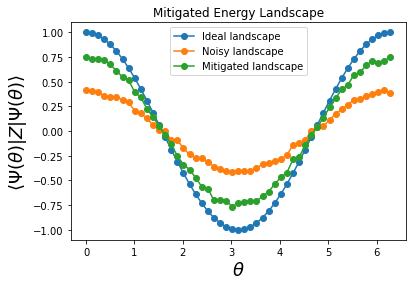

In [13]:
results_zne = []
for theta in thetas:
    results_zne.append(
        mitigated_expectation(theta, backend, readout_qubit, samples, hamiltonian, program, fac)
    )

_ = plt.figure()
_ = plt.plot(thetas, np.cos(thetas), "o-", label="Ideal landscape")
_ = plt.plot(thetas, results, "o-", label="Noisy landscape")
_ = plt.plot(thetas, results_zne, "o-", label="Mitigated landscape")
_ = plt.xlabel(r"$\theta$", fontsize=18)
_ = plt.ylabel(r"$\langle \Psi(\theta) | Z | \Psi(\theta) \rangle$", fontsize=18)
_ = plt.legend()
_ = plt.title("Mitigated Energy Landscape")
plt.show()

In the energy landscape plot, we can see that the noise has flattened the unmitigated 
landscape and with error mitigation it has become peaked again. Therefore, we expect 
the optimization loop to have better convergence with ZNE applied.

Run VQE routine with ZNE

In [14]:
res_zne = optimize.minimize(
    mitigated_expectation,
    init_angle,
    args=(backend, readout_qubit, samples, hamiltonian, program, fac),
    method="Nelder-Mead",
    options={"xatol": 1.0e-3, "fatol": 1.0e-2},
)
print(res_zne)

 final_simplex: (array([[3.08437042],
       [3.084375  ]]), array([-0.79566667, -0.79533333]))
           fun: -0.7956666666666666
       message: 'Optimization terminated successfully.'
          nfev: 45
           nit: 16
        status: 0
       success: True
             x: array([3.08437042])


We can see that the convergence to the minimum energy is enhanced by applying ZNE.


## Conclusion

While the VQE algorithm is generally considered to be robust to noise 
[[2]](#References), at the noise level modeled in this example, the 
accumulation of errors results in loss of accuracy and additional iterations 
required to reach convergence. Adding ZNE then improves the convergence of the 
algorithm to the minimum energy. The result is also demonstrated in the energy 
landscape plot, where the noisy landscape is noticeably flatter than the landscape 
generated with ZNE.

Note: In this example, a small ansatz was used to keep the runtime within acceptable 
limits. ZNE generally performs better on longer circuits, but there is a tradeoff with 
execution time.


## References
[1] Rigetti Computing (2018) Grove (Version 1.7.0) 
[[Source code].](https://github.com/rigetti/grove/blob/master/grove/pyvqe/vqe.py)

[2] [[VQE tutorial in pyQuil / Grove].](https://grove-docs.readthedocs.io/en/latest/vqe.html)

This final block displays information about Mitiq, installed packages, and Python version/platform

In [16]:
mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.13.0dev

Core Dependencies
-----------------
Cirq Version:	0.13.1
NumPy Version:	1.20.3
SciPy Version:	1.7.3

Optional Dependencies
---------------------
PyQuil Version:	3.0.1
Qiskit Version:	0.32.1
Braket Version:	1.14.0

Python Version:	3.7.7
Platform Info:	Linux (x86_64)
